# Exploratory Analysis of the Chemical Data Reporting (CDR) Dataset: 
## Presentation to Occupational Exposure Team on May 21, 2024
**Author:** Jacob Kvasnicka <br>

## Introduction

This notebook presents an exploratory analysis of the Chemical Data Reporting (CDR) dataset for the year 2020. The goal of this analysis is to determine whether this dataset can be effectively leveraged to support our project objectives.

**Project Aim:** Predict worker exposures based solely on chemical structure and related information.

## Notebook Outline

1. **Data Loading & Initial Inspection**
2. **Data Cleaning & Preparation**
3. **Data Visualization Post-Processing**
4. **Model Setup & Execution**
      - Regression Analysis: Predicting continuous variables like maximum concentration levels
      - Multi-label Classification: Predicting presence of categories like industrial subsectors
5. **Discussion:** Do we continue to invest in this dataset, or should we explore alternative datasets or methodologies?

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import utilities as utils
import rdkit_helper
import model
import plot

In [2]:
data_config = {
    'index_col' : 'CHEMICAL ID',
    'chem_id_col' : 'CHEMICAL ID',
    'chem_id_type_col' : 'CHEMICAL ID TYPE',
}

path_config = {
    'cdr_file' : 'Input/Raw/CDR/2020/2020 CDR Industrial Processing and Use Information.csv',
    'smi_file' : 'Input/Raw/CDR/2020/chemical_ids.smi'
}

## 1. Data Loading & Initial Inspection

### CDR Dataset

1. Load the raw CDR dataset for 2020
2. Examine the dataset's structure and data types
3. Identify potentially useful variables for modeling
4. Identify any preprocessing steps required for modeling

In [3]:
raw_data = pd.read_csv(path_config['cdr_file'])

raw_data.dropna(how='all')

C:\Users\jmank\AppData\Local\Temp\ipykernel_11592\3013437274.py:1: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(path_config['cdr_file'])


,CHEMICAL REPORT ID,CHEMICAL NAME,CHEMICAL ID,CHEMICAL ID W/O DASHES,CHEMICAL ID TYPE,DOMESTIC PARENT COMPANY NAME,DOMESTIC PC ADDRESS LINE1,DOMESTIC PC ADDRESS LINE2,DOMESTIC PC CITY,DOMESTIC PC COUNTY / PARISH,...,INDUSTRIAL FUNCTION CATEGORY,IND FUNCT CAT OTHER DESC,JOINT FC CODE,JOINT FUNCTION CATEGORY,JOINT FUNCT CAT OTHER DESC,IND PV PCT,IND SITES CODE,INDUSTRIAL SITES,IND WORKERS CODE,INDUSTRIAL WORKERS
0,711448.0,"(Polyisobutenyl)dihydro-2,5-furandione esters ...",18849,18849.0,Accession Number,CBI,CBI,CBI,CBI,CBI,...,Lubricants and lubricant additives,NaN,NaN,NaN,NaN,100,NKRA,Not Known or Reasonably Ascertainable,NKRA,Not Known or Reasonably Ascertainable
1,728903.0,"(Polyisobutenyl)dihydro-2,5-furandione esters ...",18849,18849.0,Accession Number,CBI,CBI,CBI,CBI,CBI,...,Lubricants and lubricant additives,NaN,NaN,NaN,NaN,100,S4,100 – 249,W7,"1,000 – 9,999"
2,702175.0,"(Polyisobutenyl)dihydro-2,5-furandione esters ...",18849,18849.0,Accession Number,CBI,CBI,CBI,CBI,CBI,...,Corrosion inhibitor,NaN,NaN,NaN,NaN,CBI,CBI,CBI,W1,< 10
3,702175.0,"(Polyisobutenyl)dihydro-2,5-furandione esters ...",18849,18849.0,Accession Number,CBI,CBI,CBI,CBI,CBI,...,Processing aids not otherwise specified,NaN,NaN,NaN,NaN,CBI,CBI,CBI,W3,25 – 49
4,702175.0,"(Polyisobutenyl)dihydro-2,5-furandione esters ...",18849,18849.0,Accession Number,CBI,CBI,CBI,CBI,CBI,...,Corrosion inhibitor,NaN,NaN,NaN,NaN,CBI,CBI,CBI,W1,< 10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65311,724410.0,"Zirconium, dichlorooxo-",7699-43-6,7699436.0,CASRN,SOUTHERN IONICS INC.,P.O. DRAWER 1217,NaN,WEST POINT,Clay,...,Other (specify),NKRA,NaN,NaN,NaN,17,S1,< 10,NKRA,Not Known or Reasonably Ascertainable
65312,738868.0,"Zirconium, dichlorooxo-",7699-43-6,7699436.0,CASRN,UNIVAR SOLUTIONS INC.,"3075 Highland Pkwy., Ste. 200",NaN,Downers Grove,DuPage,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65313,727354.0,"Zirconium, hydroxy lactate sodium complexes",113184-20-6,113184206.0,CASRN,THE SHEPHERD MATERIAL SCIENCE CO,4900 BEECH STREET,NaN,NORWOOD,HAMILTON,...,Intermediate,NaN,NaN,NaN,NaN,100,S1,< 10,W1,< 10
65314,724218.0,"Zirconium, tetrakis[2-[bis(2-hydroxyethyl)amin...",101033-44-7,101033447.0,CASRN,CBI,CBI,CBI,CBI,CBI,...,Process regulators,NaN,NaN,NaN,NaN,50,S2,10 – 24,W5,100 – 499


This analysis focuses on entries that list a CASRN, allowing us to get molecular descriptors based on chemical structure, for modeling.

In [4]:
cdr_data = utils.load_cdr_data(path_config['cdr_file'], data_config)
N_samples = len(cdr_data)
N_chemicals = cdr_data.reset_index()['CHEMICAL ID'].nunique()

print(f'{N_samples} number of entries with CASRNs')
print(f'{N_chemicals} unique chemicals with CASRNs')

C:\Users\jmank\Repositories\ht_occupational_plus\utilities.py:30: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(csv_file).dropna(how='all')


64138 number of entries with CASRNs
8035 unique chemicals with CASRNs


#### NAICS Codes
- Provide context for understanding the industrial sector(s) and subsector(s) of each chemical.
- Each entry may have up to three NAICS codes
- Codes are provided in a raw string format that will require preprocessing

In [5]:
naics_cols = [c for c in cdr_data if 'SITE NAICS CODE' in c]

cdr_data[naics_cols]

,SITE NAICS CODE 1,SITE NAICS CODE 2,SITE NAICS CODE 3
CHEMICAL ID,,,
10016-20-3,311221 Wet Corn Milling,424690 Other Chemical And Allied Products Merc...,NaN
128446-33-3,CBI,CBI,CBI
128446-33-3,311221 Wet Corn Milling,424690 Other Chemical And Allied Products Merc...,NaN
56038-13-2,424690 Other Chemical And Allied Products Merc...,NaN,NaN
99-20-7,CBI,CBI,CBI
...,...,...,...
7699-43-6,325188 All Other Basic Inorganic Chemical Manu...,NaN,NaN
7699-43-6,424690 Other Chemical And Allied Products Merc...,NaN,NaN
113184-20-6,325188 All Other Basic Inorganic Chemical Manu...,325199 All Other Basic Organic Chemical Manufa...,NaN


#### Additional Exposure-Relevant Variables
- Domestic production volume, number of workers, maximum concentration, and physical forms of chemicals.
- Each variable is currently formatted as strings and will need conversion into numerical values
- Data cleaning will be needed to filter out or impute values that are "CBI", etc.

In [6]:
cdr_data['2019 DOMESTIC PV']

CHEMICAL ID
10016-20-3         CBI
128446-33-3    141,314
128446-33-3        CBI
56038-13-2           0
99-20-7            CBI
                ...   
7699-43-6          CBI
7699-43-6          NaN
113184-20-6        CBI
101033-44-7        CBI
101033-44-7        CBI
Name: 2019 DOMESTIC PV, Length: 64138, dtype: object

In [7]:
cdr_data['WORKERS'].unique()

array(['CBI', '100 – 499', nan, 'Not Known or Reasonably Ascertainable',
       '10 – 24', '< 10', '50 – 99', '25 – 49', '1,000 – 9,999',
       '500 – 999', '10,000+'], dtype=object)

In [8]:
cdr_data['MAXIMUM CONCENTRATION'].unique()

array(['CBI', '30% – < 60%', nan, 'Not Known or Reasonably Ascertainable',
       '90% +', '1% – < 30%', '60% – < 90%', '< 1%'], dtype=object)

In [9]:
cdr_data['PHYSICAL FORM(S)']

CHEMICAL ID
10016-20-3                            Dry Powder
128446-33-3                               Liquid
128446-33-3                                  NaN
56038-13-2                            Dry Powder
99-20-7                               Dry Powder
                             ...                
7699-43-6      Pellets or Large Crystals, Liquid
7699-43-6                                    NaN
113184-20-6                               Liquid
101033-44-7                                  NaN
101033-44-7                                  NaN
Name: PHYSICAL FORM(S), Length: 64138, dtype: object

## Molecular Descriptors from RDKit as Features

- Obtained molecular descriptors from RDKit, a widely used Python package for computational chemistry
- Extracted features from QSAR-ready SMILES strings using a standardization workflow by Kamel Mansouri et al. The workflow filters out chemicals unsuitable for modeling, such as inorganics, ensuring data integrity.
- Focused on discrete-valued descriptors, including atom types and chemical groups

In [10]:
smiles_for_casrn = utils.load_qsar_ready_smiles(path_config['smi_file'])

descriptors = rdkit_helper.get_2d_descriptors(
    smiles_for_casrn, 
    data_config['chem_id_col']
)

descriptors

[10:42:03] Explicit valence for atom # 4 B, 4, is greater than permitted
[10:42:03] Explicit valence for atom # 1 B, 4, is greater than permitted
[10:42:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[10:42:04] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 11 12 13 14 15 16 17 18
[10:42:04] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 18 19 20 21 22 23
[10:42:04] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15 16 17 19 20 21 25 27 28
[10:42:04] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 11 12 13 14 15 16 17 18


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
CHEMICAL ID,,,,,,,,,,,,,,,,,,,,,
10016-20-3,11.216799,-2.148030,11.216799,0.998871,0.117489,972.846,912.366,972.316941,384,0,...,0,0,0,0,0,0,0,0,0,0
128446-33-3,12.077597,-2.170340,12.077597,0.529048,0.060586,1205.166,1120.494,1204.484400,480,0,...,0,0,0,0,0,0,0,0,0,0
56038-13-2,10.149170,-1.897767,10.149170,0.125053,0.348881,397.635,378.483,396.014551,136,0,...,0,0,0,0,0,0,0,0,0,0
99-20-7,9.838983,-1.722065,9.838983,0.667174,0.243258,342.297,320.121,342.116212,136,0,...,0,0,0,0,0,0,0,0,0,0
57-50-1,9.997826,-2.221748,9.997826,0.668633,0.237891,342.297,320.121,342.116212,136,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67859-51-2,10.554993,-1.227529,10.554993,0.070278,0.333295,292.244,276.116,292.090665,114,0,...,0,0,0,0,0,0,0,0,0,0
14025-21-9,10.554993,-1.227529,10.554993,0.070278,0.333295,292.244,276.116,292.090665,114,0,...,0,0,0,0,0,0,0,0,0,0
14639-98-6,5.205391,0.627506,5.205391,0.627506,0.664511,273.426,258.306,273.064591,92,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Data Cleaning & Preparation

### Preprocessing Numerical Variables for Regression

- **2019 Domestic Production Volume (PV)**: Convert strings representing production volumes into numerical values.
- **Maximum Concentration**: Translate concentration ranges (e.g., '30% – < 60%') into midpoint percentages to reflect the average concentration level.
- **Number of Workers**: Convert worker range categories into numerical midpoints to approximate the average number of workers exposed.
- Made assumptions about plausible lower and upper boundaries for ranges, taking the midpoints, e.g., "< 10 workers" = 5.
- Aggregated data by chemical, using the median value, to ensure each unique chemical is represented by a single row in our dataset, preventing any single chemical from disproportionately influencing the model outcomes due to repeated entries.

In [11]:
continuous_cols = [
    '2019 DOMESTIC PV',
    'MAXIMUM CONCENTRATION',
    'WORKERS'
]

cdr_data[continuous_cols]

,2019 DOMESTIC PV,MAXIMUM CONCENTRATION,WORKERS
CHEMICAL ID,,,
10016-20-3,CBI,CBI,CBI
128446-33-3,"141,314",30% – < 60%,100 – 499
128446-33-3,CBI,NaN,NaN
56038-13-2,0,Not Known or Reasonably Ascertainable,Not Known or Reasonably Ascertainable
99-20-7,CBI,90% +,10 – 24
...,...,...,...
7699-43-6,CBI,30% – < 60%,10 – 24
7699-43-6,NaN,NaN,NaN
113184-20-6,CBI,30% – < 60%,< 10


In [12]:
kwargs_for_col = {
    '2019 DOMESTIC PV' : {
        'agg_func' : 'median'
    },
    'MAXIMUM CONCENTRATION' : {  
        'lower_bound' : 0.5,  # "< 1%"
        'upper_bound' : 95.,  # "90% +"
        'agg_func' : 'median'
    },
    'WORKERS' : {
        'lower_bound' : 5.,  # "< 10" 
        'upper_bound' : 15000.,  # "10,000+"
        'agg_func' : 'median'
    }
}

continuous_data = utils.create_continuous_data(
    cdr_data[continuous_cols], 
    by=data_config['chem_id_col'],
    kwargs_for_col=kwargs_for_col
) 

In [13]:
continuous_data

,2019 DOMESTIC PV,MAXIMUM CONCENTRATION,WORKERS
CHEMICAL ID,,,
100-01-6,NaN,92.5,NaN
100-10-7,NaN,92.5,7.5
100-15-2,NaN,NaN,NaN
100-18-5,2075408.0,92.5,299.5
100-20-9,NaN,NaN,NaN
...,...,...,...
99742-80-0,0.0,NaN,NaN
998-30-1,340274.0,92.5,74.5
998-40-3,0.0,92.5,7.5


#### Spearman's rank correlation coefficient post-processing
- Moderate positive correlation between the domestic production volume and number of workers
- This suggests that companies with larger production volumes tend to have more workers exposed

In [14]:
continuous_data.corr(method='spearman').round(2)

,2019 DOMESTIC PV,MAXIMUM CONCENTRATION,WORKERS
2019 DOMESTIC PV,1.00,-0.00,0.43
MAXIMUM CONCENTRATION,-0.00,1.00,0.02
WORKERS,0.43,0.02,1.00


### Preprocessing Categorical Information

For our classification tasks, categorical information such as sectors, subsectors, and physical forms have been transformed into a numerical format suitable for machine learning:

- **One-hot Encoding**: Converted sectors, subsectors, and physical forms into binary variables. Each category is represented as a separate column, where `1` indicates presence and `0` indicates absence of the category.
- **Aggregating Categorical Data**: Similar to the continuous variables, categorical data has been aggregated by chemical. I've used the maximum value for aggregation, meaning if *any* entry for a chemical indicates presence for a category, the aggregated result for that chemical will also indicate presence for that category.


In [15]:
cdr_data[naics_cols]

,SITE NAICS CODE 1,SITE NAICS CODE 2,SITE NAICS CODE 3
CHEMICAL ID,,,
10016-20-3,311221 Wet Corn Milling,424690 Other Chemical And Allied Products Merc...,NaN
128446-33-3,CBI,CBI,CBI
128446-33-3,311221 Wet Corn Milling,424690 Other Chemical And Allied Products Merc...,NaN
56038-13-2,424690 Other Chemical And Allied Products Merc...,NaN,NaN
99-20-7,CBI,CBI,CBI
...,...,...,...
7699-43-6,325188 All Other Basic Inorganic Chemical Manu...,NaN,NaN
7699-43-6,424690 Other Chemical And Allied Products Merc...,NaN,NaN
113184-20-6,325188 All Other Basic Inorganic Chemical Manu...,325199 All Other Basic Organic Chemical Manufa...,NaN


In [16]:
naics_cols = [c for c in cdr_data if 'SITE NAICS CODE' in c]
combined_subsectors = utils.extract_subsectors(cdr_data[naics_cols])

In [17]:
combined_sectors = utils.extract_sectors(combined_subsectors)

In [18]:
subsector_data = utils.create_binary_data(
    combined_subsectors, 
    by=data_config['chem_id_col'],
    agg_func='max'
)

subsector_data

,3329,4249,4235,2211,4214,3112,3315,4861,1111,4539,...,4226,4241,4461,3391,4231,5232,3363,2122,3116,2111
CHEMICAL ID,,,,,,,,,,,,,,,,,,,,,
100-01-6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100-10-7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100-15-2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100-18-5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100-20-9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99742-80-0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998-30-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998-40-3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
sector_data = utils.create_binary_data(
    combined_sectors, 
    by=data_config['chem_id_col'],
    agg_func='max'
)

sector_data

,32,21,56,52,44,92,31,33,55,45,49,48,54,81,22,11,23,42
CHEMICAL ID,,,,,,,,,,,,,,,,,,
100-01-6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100-10-7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
100-15-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100-18-5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100-20-9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99742-80-0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998-30-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998-40-3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
physical_forms = utils.extract_physical_forms(cdr_data['PHYSICAL FORM(S)'])

In [21]:
forms_data = utils.create_binary_data(
    physical_forms, 
    by=data_config['chem_id_col'],
    agg_func='max',
    drop_columns=['NKRA']
)

forms_data

,Pellets or Large Crystals,Gas or Vapor,Liquid,Other Solid,Dry Powder,Water or Solvent Wet Solid
CHEMICAL ID,,,,,,
100-01-6,0,0,0,0,1,0
100-10-7,0,0,0,0,1,0
100-15-2,0,0,0,0,0,0
100-18-5,0,1,1,0,0,0
100-20-9,1,0,0,0,1,0
...,...,...,...,...,...,...
99742-80-0,0,0,1,0,0,0
998-30-1,0,0,1,0,0,0
998-40-3,0,0,1,0,0,0


## 3. Data Visualization Post-Processing

### Visualization of Regression Variables
- The following histograms display the distribution of each numerical variable after initial preprocessing but before any tranformations. 
- The histograms reveal significant skew in the distributions, which can adversely affect model performance.
- This skewness will be addressed in the analysis by applying transformations to make data more Gaussian-like.

array([[<Axes: title={'center': '2019 DOMESTIC PV'}>,
        <Axes: title={'center': 'MAXIMUM CONCENTRATION'}>],
       [<Axes: title={'center': 'WORKERS'}>, <Axes: >]], dtype=object)

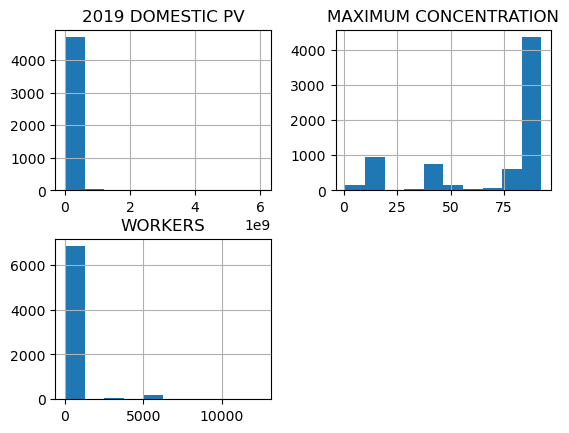

In [22]:
continuous_data.hist()

### Visualization of Classification Variables
- Reveals substantial **class imbalance**; some categories have substantially more samples than others, which can skew the model's performance and its ability to generalize.
- Specialized techniques to handle class imbalance have not yet been explored in this initial analysis.

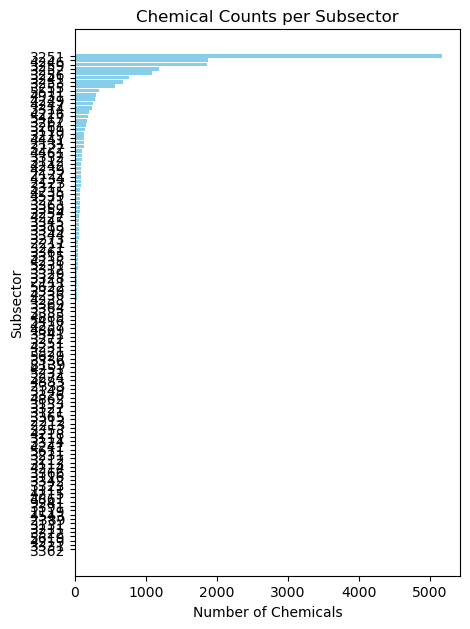

In [23]:
subsector_counts = subsector_data.sum()

_ = plot.chemical_counts(
    subsector_counts, 
    'Chemical Counts per Subsector', 
    'Number of Chemicals', 
    'Subsector'
)

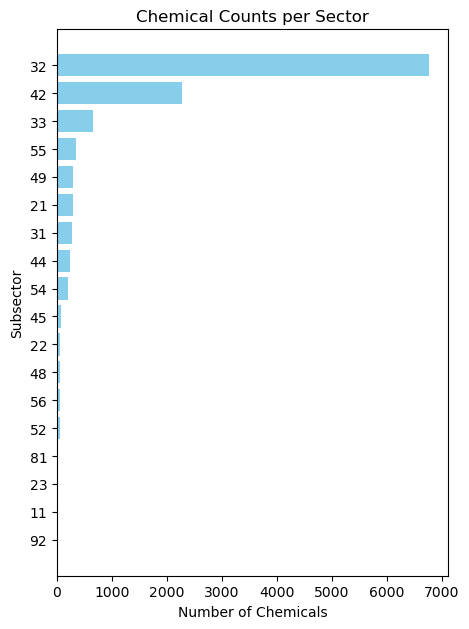

In [24]:
sector_counts = sector_data.sum()

_ = plot.chemical_counts(
    sector_counts, 
    'Chemical Counts per Sector', 
    'Number of Chemicals', 
    'Subsector'
)

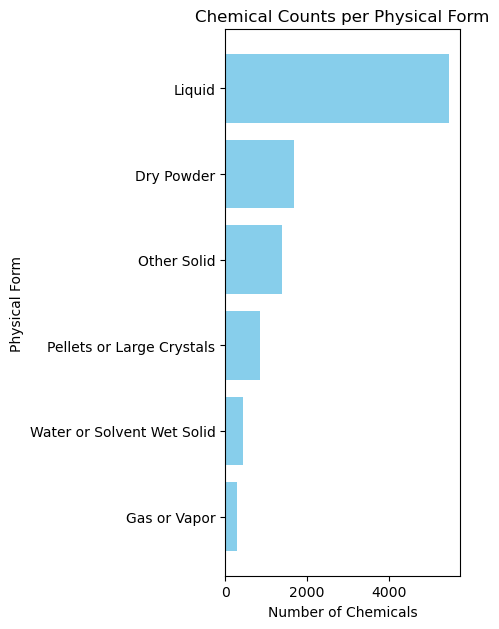

In [25]:
form_counts = forms_data.sum()

_ = plot.chemical_counts(
    form_counts, 
    'Chemical Counts per Physical Form', 
    'Number of Chemicals', 
    'Physical Form'
)

## 4. Model Setup & Execution

This section constructs a series of machine learning models to predict outcomes related to chemical exposure.

### Regression Analysis
- **Algorithm**: Random Forests, known for robust performance with minimal tuning.
- **Data Splitting**: 80% for training and 20% for testing.
- **Pipeline** (applied after splitting to avoid "data leakage"):
  - Impute missing values using the median of the training set.
  - Apply a Yeo-Johnson transformation to make the target variable more Gaussian-like.
- **Evaluation Metrics**: R² (coefficient of determination), RMSE (root mean squared error), MedAE (median absolute error).

In [26]:
discrete_descriptors = descriptors.select_dtypes('int')
descriptors_plus_subsectors = pd.concat([discrete_descriptors, subsector_data], axis=1, join='inner')

regression_instructions = {
    '2019 Domestic PV (descriptors only)' : {
        'X' : discrete_descriptors, 
        'y' : continuous_data['2019 DOMESTIC PV']
    }, 
    '2019 Domestic PV (descriptors & subsectors)' : {
        'X' : descriptors_plus_subsectors, 
        'y' : continuous_data['2019 DOMESTIC PV']
    },
    'Workers (descriptors only)' : {
        'X' : discrete_descriptors, 
        'y' : continuous_data['WORKERS']
    }, 
    'Workers (descriptors & subsectors)' : {
        'X' : descriptors_plus_subsectors, 
        'y' : continuous_data['WORKERS'],        
    },
    'Max Conc. (descriptors only)' : {
        'X' : discrete_descriptors, 
        'y' : continuous_data['MAXIMUM CONCENTRATION']
    }, 
    'Max Conc. (descriptors & subsectors)' : {
        'X' : descriptors_plus_subsectors, 
        'y' : continuous_data['MAXIMUM CONCENTRATION'],        
    }
}

In [27]:
print(f'Execution time for {len(regression_instructions)} models:')

Execution time for 6 models:


In [28]:
%%time

reg_results = {}  # initialize

for k, data in regression_instructions.items():
    
    res = model.regression_analysis(data['X'], data['y'])
    performances = model.evaluate_regression(res['y_test'], res['y_pred'])
    performances['N'] = len(res['y_train'])  # sample size

    reg_results[k] = {
        'y_test' : res['y_test'],
        'y_pred' : res['y_pred'],
        'performances' : performances
    }

CPU times: total: 5.12 s
Wall time: 13.5 s


### Regression Results Summary

- Majority of the models do not provide reliable or accurate predictions
- The only exception might be the Maximum Concentration model

In [29]:
pd.DataFrame({k : v['performances'] for k, v in reg_results.items()}).T

,R2,RMSE,MedAE,N
2019 Domestic PV (descriptors only),-0.007417,4.383145e+07,21.593724,2072.0
2019 Domestic PV (descriptors & subsectors),-0.008570,4.385653e+07,20.220554,2072.0
Workers (descriptors only),0.004994,6.866561e+02,15.193380,3236.0
Workers (descriptors & subsectors),0.017122,6.824584e+02,14.725883,3236.0
Max Conc. (descriptors only),0.076223,2.840211e+01,13.806463,3289.0
Max Conc. (descriptors & subsectors),0.224299,2.602642e+01,12.091617,3289.0


### Classification Analysis
- **Algorithm**: Random Forests Classification.
- **Pipeline Setup**:
  - Similar to the regression setup: median imputation for missing values.
    
#### Classification Metrics

- **Precision**: The precision is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive when it is actually negative.
- **Recall**: The recall is the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
- **F1-Score**: Harmonic mean of precision and recall. The value ranges from zero to one and will be high only if both precision and recall are high.
- **Support**: Number of actual occurrences of the category in the dataset.

In [30]:
classification_instructions = {
    'Physical Form(s) (descriptors only)' : {
        'X' : discrete_descriptors, 
        'y' : forms_data
    }, 
    'Physical Form(s) (descriptors & subsectors)' : {
        'X' : descriptors_plus_subsectors, 
        'y' : forms_data
    },
    'Sectors' : {
        'X' : discrete_descriptors,
        'y' : sector_data
    },
    'Subsectors' : {
        'X' : discrete_descriptors, 
        'y' : subsector_data
    }
}

In [31]:
class_results = {}  # initialize

for k, data in classification_instructions.items():

    res = model.classification_analysis(data['X'], data['y'])
    class_results[k] = {
        'y_test' : res['y_test'],
        'y_pred' : res['y_pred'],
        'performances' : classification_report(
            res['y_test'], 
            res['y_pred'], 
            target_names=list(data['y'])
        )
    }

C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmank\min

### Classification Model Evaluation

- **Physical Forms**: Promising results for physical forms with large sample sizes, like liquids, but the models struggle with less common forms such as pellets, crystals. Including subsector information marginally improved predictions for some categories.
- **Sector Presence**: Effective predictions for sector `32`, but performance across other sectors is poor, likely due to class imbalances and insufficient training samples.
- **Subsector Presence**: A few subsectors, such as `3251` and `4246`, are predicted with moderate success. Most other subsectors have very low accuracy, pointing to significant challenges due to class imbalance and limited data.

In [32]:
for k, results in class_results.items():
    print(k)
    print(results['performances'])

Physical Form(s) (descriptors only)
                            precision    recall  f1-score   support

 Pellets or Large Crystals       0.36      0.15      0.21        92
              Gas or Vapor       0.58      0.39      0.47        18
                    Liquid       0.82      0.88      0.85       655
               Other Solid       0.39      0.17      0.24       143
                Dry Powder       0.60      0.39      0.48       195
Water or Solvent Wet Solid       0.50      0.21      0.29        34

                 micro avg       0.74      0.62      0.67      1137
                 macro avg       0.54      0.37      0.42      1137
              weighted avg       0.68      0.62      0.64      1137
               samples avg       0.69      0.63      0.64      1137

Physical Form(s) (descriptors & subsectors)
                            precision    recall  f1-score   support

 Pellets or Large Crystals       0.75      0.13      0.22        92
              Gas or Vapor      

## Main Takeaways

- **Regression Models**: Generally showed low predictive accuracy, with modest success in predicting maximum concentration levels.
- **Classification Models**: Generally performed better, particularly for categories with sufficient sample sizes like liquid physical form and certain sectors, indicating some predictive utility.
- **Class Imbalance Challenges**: Significant class imbalance affected model performance, particularly for rare categories. This might be addressed to some extent with more data or specialized machine learning techniques.

## Discussion

- **Preliminary Findings**: The exploratory analysis has provided initial insights into the dataset, but the results are very preliminary.
- **Refinement Opportunities**: There are numerous potential refinements that could be applied. However, before proceeding, it's crucial to assess the overall value of potential refinements in light of our project objectives.
- **Decision Point**: Do we continue to invest in this dataset, or should we explore alternative datasets or methodologies?